In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os 
os.chdir("/content/drive/My Drive/Colab Notebooks/Style Transfer")

# New Section

In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [ ]:
content_name = "content.jpg"
style_name   = "style.jpg"
result_name  = "zurich_strarry"

Iterations = 10

totalVariation_weight = 1.
style_weight = 1.
content_weight =0.025


width, height = load_img(content_name).size
result_width = 400
result_height = int(result_width * width / height)


content_layer = "block5_conv2"

style_layer   = ["block1_conv1",
               "block2_conv1",
               "block3_conv1",
               "block4_conv1",
               "block5_conv1"]

In [ ]:
def process_img(img_path):
  
  img = load_img(img_path, 
                target_size = (result_width, result_height))
  img = img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img = preprocess_input(img)
  return img

def deprocess(img):
  
  img = img.reshape((result_width, result_height, 3))
  
  biases = [103.939, 116.779, 123.68]
  for bias in enumerate(biases):
    img[:,:, bias[0]] += bias[1]
   
  img = img[:,:, ::-1]
  img = np.clip(img, 0, 255).astype("uint8")
  
  return img

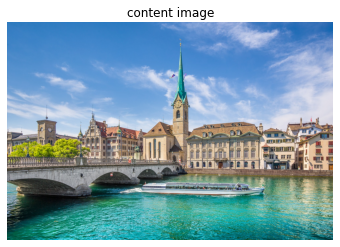

In [ ]:
plt.figure()
plt.title("content image")
img = load_img(content_name)
plt.axis("off")
plt.imshow(img)

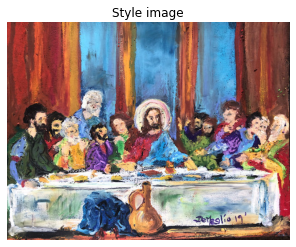

In [ ]:
plt.figure()
plt.title("Style image")
img = load_img(style_name)
plt.axis("off")
plt.imshow(img)

In [ ]:
content_tensor = K.constant(process_img(content_name))
style_tensor   = K.constant(process_img(style_name))

result_tensor  = K.placeholder(dtype = "float32", 
                                shape = (1, result_width, result_height, 3))

input_tensor   = K.concatenate([content_tensor, style_tensor, result_tensor],  0)
print("Input tensor shape:{} ".format(input_tensor.shape))

Input tensor shape:(3, 400, 599, 3) 


In [ ]:
model = VGG19(include_top=False,
              weights="imagenet",
              input_tensor=input_tensor)
layer_outputs = {layer.name: layer.output for layer in model.layers}

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
def gram_matrix(x):
  x = K.permute_dimensions(x, [2, 0, 1])
  x = K.batch_flatten(x)
  gram = K.dot(x, K.transpose(x))
  return gram

In [ ]:
def compute_style_loss(style, result):
  
  style_gram = gram_matrix(style)
  result_gram= gram_matrix(result)
  
  loss = K.sum(K.square(style_gram - result_gram))
  return loss

In [ ]:
def compute_content_loss(content, result):
  
  loss = K.sum(K.square(content - result))
  return loss

In [ ]:
def total_variation_loss(x):
  
  dx = K.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
  dy = K.square(x[:, :-1, :-1, :] - x[:, -1:, 1:, :])
  
  loss = K.sum(K.pow(dx + dy, 1.25))
  
  return loss

In [ ]:
loss = K.variable(0.0)
layer_features = layer_outputs[content_layer]
content_features = layer_features[0, :, :, :]
result_features = layer_features[2, :, :, :]

loss = loss + content_weight * compute_content_loss(content_features, result_features)

for layer in style_layer:
  layer_features = layer_outputs[layer]
  style_features = layer_features[1, :, :, :]
  result_features = layer_features[2, :, :, :]

  style_loss = compute_style_loss(style_features, result_features)
  loss = loss + style_weight * style_loss / len(style_layer)

loss = loss + totalVariation_weight * total_variation_loss(content_tensor)

In [ ]:
grads = K.gradients(loss, result_tensor)[0]
print(result_tensor.shape)
fetch_grads_loss = K.function([result_tensor], [loss, grads])

def eval_grads_loss(x):
  x = x.reshape((1, result_width, result_height, 3))
  loss_vlaue, grads_values = fetch_grads_loss([x])
  grads_values = grads_values.flatten().astype("float64")
  return loss_vlaue, grads_values

(1, 400, 599, 3)



In [ ]:
class Evaluator:
  def __init__(self):
    self.loss_value = None
    self.grads_value = None

  def loss(self, x):
    assert self.loss_value is None
    self.loss_value, self.grads_value = eval_grads_loss(x)
    return self.loss_value

  def grads(self, x):
    self.loss_value = None
    return self.grads_value

evaluator = Evaluator()


In [ ]:
x = process_img(content_name)

for iteration in range(Iterations):
  print(f"Iteration: {iteration} started")

  x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), evaluator.grads, maxfun = 20)
  img = deprocess(x.copy())
  result_path = result_name + str(f"_at_iteration_{iteration}.jpg")
  save_img(result_path, img)
  print(f"Tmage {result_path} saved.")


Iteration: 0 started
Tmage zurich_strarry_at_iteration_0.jpg saved.
Iteration: 1 started
Tmage zurich_strarry_at_iteration_1.jpg saved.
Iteration: 2 started
Tmage zurich_strarry_at_iteration_2.jpg saved.
Iteration: 3 started
Tmage zurich_strarry_at_iteration_3.jpg saved.
Iteration: 4 started
Tmage zurich_strarry_at_iteration_4.jpg saved.
Iteration: 5 started
Tmage zurich_strarry_at_iteration_5.jpg saved.
Iteration: 6 started
Tmage zurich_strarry_at_iteration_6.jpg saved.
Iteration: 7 started
Tmage zurich_strarry_at_iteration_7.jpg saved.
Iteration: 8 started
Tmage zurich_strarry_at_iteration_8.jpg saved.
Iteration: 9 started
Tmage zurich_strarry_at_iteration_9.jpg saved.


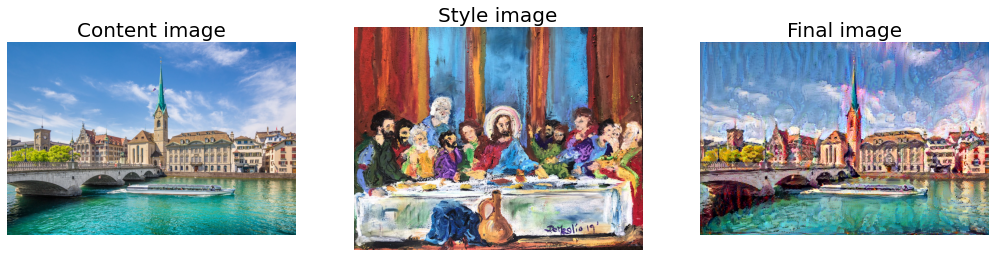

In [ ]:
plt.figure(figsize=(30, 30))
plt.subplot(5, 5, 1)
content_img = load_img(content_name)
plt.axis("off")
plt.title("Content image", fontsize=20)
plt.imshow(content_img)

plt.subplot(5, 5, 2)
style_img = load_img(style_name)
plt.title("Style image", fontsize=20)

plt.axis("off")
plt.imshow(style_img)

plt.subplot(5, 5, 3)
result_img = x.copy()
plt.title("Final image", fontsize=20)
plt.axis("off")
plt.imshow(deprocess(result_img))